# Sentiment Analysis and Recommendation Engines in Spark

This continues the August/September 2018 Portland Data Science Group's Applied Data Science Series on Sentiment Analysis, and the November/December 2017 sessions using BoardGameGeek data.  The data was scraped and cleaned by Matt Borthwick (www.dive-into.info) from www.boardgamegeek.com.  The full rating data set includes around 5M ratings for the 400 most popular games.  Additionally, there are 800k reviews with english text. 

So as a practical goal, I want to complete some projects in Spark.  I currently have small versions working in Python for text analysis,
but I never really finished the recommendation engines.  I would like to port a known project to Spark, so I am prepared to try a larger problem.
This data is tiny, so it is a nice play set to get used to working with Spark.  This is pretty small data: around 200MB for comments, and 150MB for ratings. 

As for the "business goal", there are two aspects to the project: How do you recommend new products to users based on past ratings.  For example new movies or music to fans.  That seems obviously useful for both consumers and for the business.
A second less direct goal is to analyze the sentiment of a set of text.  This second task requires labelled data, which is provided here by the game scores.  In that sense we are training machine learning algorithms to recognize "game good" or "game bad".  How is this useful? Well, it can parse unscored text and give an estimated score, which could be used by aggregator sites.  The text analysis could also be used to extend the recommendations to note other references, or other similarities to other users.
Third, this sort of text analysis might also be used to pick out consumer campaigns that otherwise clutter up user reviews. An example from video games is in Steam's reviews where Paradox studios faced a sustained campaign where all of their games were rated negatively due to the publisher's pricing tactics.  As someone looking to buy a Paradox game at a later date, I don't care about this campaign when judging the quality of the games.

Prior projects tried to forecast a users scores directly and tried to minimize the RMSE of the scores.  I'm not sure that's useful overall, who cares about the distinction between 7.2 and 8.0?
It's also quite hard to improve over simple guesses, e.g. all scores set to the mean 7.2, given how clustered the data are.
That reflects that these are popular games, and thus likely to be well received by most players.
The weighted RMSE (which includes an inverse weighting based on the number of reviews gives more impetus to the rarer negative reviews).
Alternatively, 
Prior work threw neural networks at this as well, but I don't think it's worth the effort in this case (finicky, small gains, hard to understand).

See the work in "PDSG\_recommend" for other explorations.

## TODO

- Use spark CountVectorizer (naive bayes (done), linear regression)
- Cluster users and games
- ALS

## Possible questions:

The data have already been substantially cleaned, with minor issues unrelated to gathering the data (e.g. old ratings below one,
repeated comments/ratings, e.g. all ones).

### Exploratory questions:
- Number of reviews per game/user
- Average review score by game/user
- Spread in scores (std dev, inter-quartile range)
- Game metadata: types, designers.
- Pattern exploration: Which games did people rate at all?

## Analysis/Modelling questions

- Recommend new games based on similarities with others interests.

- Cluster games based on game metadata (designers, artists, mechanisms, text)
- Cluster users based on games played.

- User analysis:
   Are there multiple audiences here? "Hardcore" vs "casual" to use the gamer terms.
   - use game metadata to segment reviews.

Handling sparsity:
- Use global function to estimate missing values.  Treat them as the average user.
         
Latent factor analysis with ALS algorithm
       -decompose matrix into 2 matrices.  user features vs game features.
       - if $S_{i,j}$ is matrix element for user $i$'s score of game $j$, then
       decompose S=UW, where U is $N_{user} x N_{hidden}$, and $W = N_{hidden} x N_{game}$.
       - Note that $S_{i,j}$ is a matrix with non-negative entries? Not just all eigenvalues are positive.
       Hmm, a Pauli matrix $[[0,1],[1,0]]$ also has non-negative entries, but it has eigenvalues $\pm 1$, thus is not positive.  

Text analysis:
- Naive bayes scoring for word sentiment.  
- Linear regression on word counts
- Associative rule mining (look at lift on 1 vs 2 grams.)


For the recommendation engine I aim to try k-nearest neighbours and the latent factor analysis approach.
I will also try some straightforward collaborative filtering with similarities based on user/game vectors.  I also thought about trying to analyze what games are preferred by reviewers with only a few reviews (n<5) vs many reviews (n>50).

Need to think though the optimization criteria, and include appropriate regularization to avoid overfitting.  Maybe use mean-square-error on game scores for games the user has actually reviewed?

In [1]:
#standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

%matplotlib inline
%load_ext autoreload
#save graphics as pdf too (for less revolting exported plots)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
#create the session to start using SparkSQL with Dataset/DataFrame API, which is recommended API.
conf = SparkConf().setAppName("PySpark Recommendation Engine")\
     .setAll([('spark.executor.memory','3g'),('spark.executor.cores','3'),('spark.cores.max','3')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [3]:
#Check file size
!ls -lh data/boardgame-users.csv
!ls -lh data/boardgame-comments-english.csv

#Number of lines
!wc -l data/boardgame-users.csv
!wc -l data/boardgame-comments-english.csv

-rw-rw-r-- 1 jonathan jonathan 72M Aug 31 17:16 data/boardgame-users.csv


-rw-rw-r-- 1 jonathan jonathan 192M Aug 12 11:32 data/boardgame-comments-english.csv


5148626 data/boardgame-users.csv


841646 data/boardgame-comments-english.csv


In [4]:
#read in the data.  (13MB or so)
#(N.B. I put Matt's header on it's own line, which is skipped, and added the UserID)
#initial playing data
df_rating=spark.read.csv("data/boardgame-users.csv",header=True,schema="userID INT, gameID INT, rating FLOAT")
df_text=spark.read.csv("data/boardgame-comments-english.csv",header=True,schema="userID INT, gameID INT, rating FLOAT, comment STRING")

In [5]:
#check data formatting via head
df_text.head(n=5)

[Row(userID=172640, gameID=24068, rating=7.0, comment='Good:  Unique take on the hidden role games. The good and evil team win if they eliminate each other where the neutral team has unique objectives depending on what was dealt.   Bad:  Component quality is on the lower end. The artwork is lackluster, the card stock is flimsy, board design is uninspired.   Playing this is entertaining but its tough getting folks interested when newer games have a much better graphical presentation. '),
 Row(userID=86674, gameID=24068, rating=7.0, comment='A neat social deduction game with multiple teams and winning conditions happening at the same time.'),
 Row(userID=10643, gameID=24068, rating=7.0, comment="Good hidden roles werewolf style game that can accommodate a lot of players nicely. This game is fun if you play with the right people, who play their role and don't just attack randomly. "),
 Row(userID=31171, gameID=24068, rating=7.0, comment="Overall I hate Mafia/Werewolf, but this version is 

In [5]:
#Matt made a csv file of ids and names  Load into dataframe, put into dict.
#Currently still in Pandas formatting.
detail_df=pd.read_csv('data/boardgame-details.csv',index_col=0)
name_dict=detail_df['title'].to_dict()

In [9]:
detail_df.columns

Index(['title', 'yearpublished', 'playingtime', 'minplaytime', 'maxplaytime',
       'minage', 'minplayers', 'maxplayers', 'categories', 'mechanics',
       'families', 'designers', 'artists', 'publishers',
       'numplayervotes (1B 1R 1N 2B 2R 2N ...)',
       'agevotes (2 3 4 5 6 8 10 12 14 16 18 21+)',
       'textuse (no some mod ext max)'],
      dtype='object')

In [7]:
#How many of each category?
#detail_df['categories'].apply(str.split)
def get_cat_list(series):
    cat=[];
    for i,r in enumerate(series):
        try:
            #find all indices per game
            rlist=r.split()
            cat=cat+rlist
        except:
            print('Skipping',i)
    #cheap way to find unique elements.
    #a less stupid way would be to use a collection?
    return cat    

In [8]:
cat_list=get_cat_list(detail_df['categories'])

In [9]:
def get_counts(series):
    """get_counts( series)
    Takes a pandas series (assumed to contain strings of numbers separated by strings)
    and converts that into a count of the number of each type of number.
    The numbers are categorical variables for differing variables.
    """

    cat_list=get_cat_list(series)
    cat_unique=set(cat_list)
    cat_count=pd.Series(np.zeros(len(cat_unique)),index=cat_unique)
    for i in cat_list:
        cat_count[i]+=1
    cat_count.sort_values(ascending=False,inplace=True)    
    return cat_count
    
cat_count=get_counts(detail_df['categories'])
mech_count=get_counts(detail_df['mechanics'])

Skipping 115


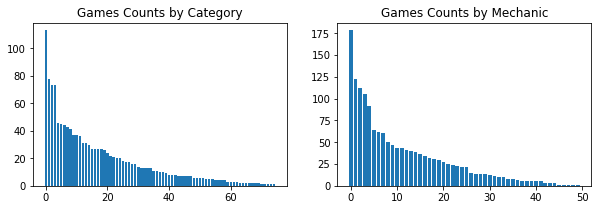

In [41]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.bar(np.arange(len(cat_count)),cat_count)
plt.title('Games Counts by Category')
plt.subplot(122)
plt.bar(np.arange(len(mech_count)),mech_count)
plt.title('Games Counts by Mechanic')
plt.show()

In [178]:
detail_df.iloc[115]

title                                                                                                                                      Jenga
yearpublished                                                                                                                               1983
playingtime                                                                                                                                   20
minplaytime                                                                                                                                   20
maxplaytime                                                                                                                                   20
minage                                                                                                                                         6
minplayers                                                                                                                        

So the first thing to note is the variation in the number of responses on a games characteristics.
Second, these are either effectively histograms, or categorical variables.
Those categorical lists might have the most relevant genre information about the game, which could be used to classify games,
and then the users (based on what they rate), and would be useful auxiliary information in recommendations.

The integer labels are used by the site as identifiers for each person or item in a given category of information, e.g.
artists/designers/publishers.

Looking over the website it seems that: 
Category is genre and theme, e.g. medical, wargame, 
Mechanism involves the type of play, dice/simulation/
The Publishers category is for any and all publishers of that game around the world.
The textuse, age and numplayers are all user polls.  (It seems a 100:1 ratio in rating/review/poll would probably hold at each stage of engagement?)

## Exploratory Analysis

I'm going to do a few things:
- check for NaN/missing values.
- check the scores look right
- check the numbers of reviews, and games.
- match up the names with the unique gameIDs (I'll find some missing entries here)
- plot the number of reviews/user and reviews/game.
- check for duplicates

In [12]:
df_rating

DataFrame[userID: int, gameID: int, rating: float]

In [42]:
#computes gamewise-means using groupBy.
game_mean=df_rating.select('gameID','rating').groupby('gameID').avg()
user_mean=df_rating.select('userID','rating').groupby('userID').avg()

In [43]:
bins=list(range(1,11))
#text for generating a histogram.  Convert to RDD, then use built in histogram
#why the flatMap?
user_hist=user_mean.select("avg(rating)").rdd.flatMap(lambda x: x).histogram(bins)

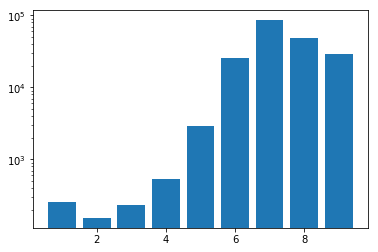

In [44]:
user_mean_bins,user_mean_val=user_hist
plt.bar(user_mean_bins[:-1],user_mean_val,log=True)
plt.show()

In [54]:
# Group ratings matrix by user and GameIDs to look at those distributions.  Looking at histograms of avg/max/min per user.
user_ratings=df_rating.select('userID','rating').groupby('userID')
game_ratings=df_rating.select('gameID','rating').groupby('gameID')

In [55]:
#Compute histogram within Spark.
# Found this magic on stackoverflow.  No idea behind reasoning for flatMap.
user_min=user_ratings.min()
user_minhist=user_min.select("min(rating)").rdd.flatMap(lambda x: x).histogram(bins)

In [56]:
user_max=user_ratings.max()
user_maxhist=user_max.select("max(rating)").rdd.flatMap(lambda x: x).histogram(bins)

In [60]:
def plot_hist(hist,title_str=None):
    """plot_hist(hist)
    hist is output from Spark RDD HIstogram call.
    hist is a tuple (bins, vals).
    Plots a bar chart using 
    Assumes linearly spaced bins.
    """
    bins,val=hist
    bins2=[0.5*(bins[k]+bins[k+1]-1) for k in range(len(bins)-1)]
    width=bins[1]-bins[0]
    #plt.bar(bins[:-1],val,width=width,log=True)
    plt.bar(bins2,val,width=width,log=True)    
    plt.xticks([2,4,6,8,10])
    print(bins2)
    if (title_str!=None):
        plt.title(title_str)
        

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


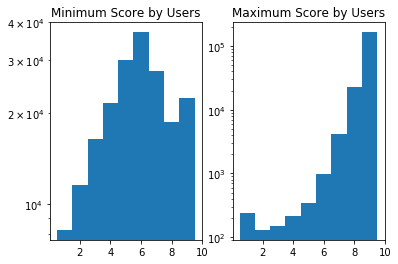

In [61]:
plt.subplot(121)
plot_hist(user_minhist,'Minimum Score by Users')
plt.subplot(122)
plot_hist(user_maxhist,'Maximum Score by Users')

In [15]:
game_count=df_rating.select('gameID').groupby('gameID').count()

In [16]:
#get number of games
game_count.persist()

DataFrame[gameID: int, count: bigint]

In [108]:
game_count.sort('count',ascending=False).show()

+------+-----+
|gameID|count|
+------+-----+
|    13|71236|
|   822|70820|
| 30549|66954|
| 36218|58567|
| 68448|55466|
|  9209|50919|
| 31260|50075|
|  3076|49560|
| 40692|45525|
|  2651|43673|
| 70323|39256|
|   478|39009|
|129622|38237|
| 14996|38021|
| 28143|35648|
|178900|34765|
|148228|33374|
| 39856|33327|
| 34635|32066|
|110327|31245|
+------+-----+
only showing top 20 rows



In [18]:
reviews_per_game_hist=game_count.select('count').rdd.flatMap(lambda x: x).histogram(buckets=20)

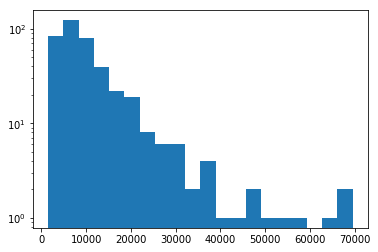

In [19]:
plot_hist(reviews_per_game_hist)

This is the number of games with a given number of reviews.
Seems to have at a minimum around 3000 reviews, and going up to just shy of 70k reviews for the most popular games. 

In [29]:
game_count.describe().show()

+-------+------------------+-----------------+
|summary|            gameID|            count|
+-------+------------------+-----------------+
|  count|               402|              402|
|   mean| 63385.90547263682|12807.52487562189|
| stddev|62511.703351741875|9733.035753206457|
|    min|                 3|             3225|
|    max|            209010|            71236|
+-------+------------------+-----------------+



In [45]:
#create view to allow SQL like calling of data. 
df_text.createOrReplaceTempView("df_Tview")

In [46]:
#quick test: lower-case and split at spaces
res=spark.sql("SELECT split(lower(comment),' ') as sc FROM df_Tview LIMIT 100")

In [47]:
#make a small dataframe to test/play with in Python.
df_s=spark.sql("SELECT * FROM df_Tview LIMIT 100").toPandas()

# NLTK text-cleaning Pipeline

Let's try doing some pre-processing here.
We'll be using Spark's MLib for these applications, rather than trying to roll our own.
Spark MLib has Linear Regression, Count-Vectorizers, TF-IDF, Naive Bayes, clustering, and an ALS algorithm for non-negative matrix factorization.

- Strip punctuation.
- lower case
- count words

In [11]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [58]:
string="Yeah, y'all say the game sucks. But I LOVE it."
#lower case

def tokenize(string):
    return nltk.word_tokenize(string.lower())    
#split at spaces.

#remove stop-words
def make_removal_list():
    stop_words=set(stopwords.words('english'))
    punc_list=[letter for letter in punctuation]
    return stop_words.union(punc_list)

def clean_words(string,removal_list):
    word_list=tokenize(string)
    return [word for word in word_list if word not in removal_list]

removal_list=make_removal_list()
clean_word_list=clean_words(string,removal_list)

In [79]:
clean_word_list

['yeah', "y'all", 'say', 'game', 'sucks', 'love']

So here we can see how much is lost by stripping out stopwords.
The actually expressed opinion is completely lost, that "but" was important.
That approach probably works great for document retrieval, but perhaps loses too much in this context.
We'll also be treating the whole comment as one big bag of words, which loses even more nuance.

Why do such violence? Well, it's easy and seemingly standard.
This is also an attempt to use spark, rather than a serious NLP project, so we'll just roll with it.


In [103]:
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.sql.functions import udf


In [59]:
clean_words_udf = udf( lambda x: clean_words(x,removal_list), returnType=ArrayType(StringType()))

In [108]:
clean_words('bleah the moo the why game',removal_list)

['bleah', 'moo', 'game']

In [61]:
df_text.select('comment',clean_words_udf('comment')).show(n=5)

+--------------------+--------------------+
|             comment|   <lambda>(comment)|
+--------------------+--------------------+
|Good:  Unique tak...|[good, unique, ta...|
|A neat social ded...|[neat, social, de...|
|Good hidden roles...|[good, hidden, ro...|
|Overall I hate Ma...|[overall, hate, m...|
|Fun social deduct...|[fun, social, ded...|
+--------------------+--------------------+
only showing top 5 rows



In [109]:
#make a new rounded score column. (corresponds to half-integer binning.  True score = rating2/2
#Include max so minimum score is 0.5
round_udf=udf(lambda x: max(int(2*x),1), IntegerType())
df_text=df_text.withColumn('rating2',round_udf('rating'))

In [114]:
#Split data into training/test
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

#Split all data 
df_text_train, df_text_test= df_text.randomSplit([0.9,0.1],seed=56565)

So one of the problems is how do you handle new instances?
Here we'll take the point of view that the testing data is completely unknown.
Thus it's not included in any of the data pipeline.  If we run into rare or unknown words, then so be it.
It's a more honest test of the algorithm.  We'll assume that the training data is a large

In [90]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, StopWordsRemover, NGram
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE
from pyspark.ml import Pipeline

In [112]:
tokenizer = Tokenizer(inputCol='comment', outputCol='words')
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
#ngram = NGram(n=2,inputCol='filtered_words', outputCol='filtered_2grams')
cv = CountVectorizer(inputCol='filtered_words', outputCol='features', minDF=20)
nb = NaiveBayes(featuresCol='features',labelCol='rating2',predictionCol='prediction',smoothing=0.1)
pipeline=Pipeline(stages=[tokenizer,remover,cv,nb])

In [127]:
#Grab training subset of data
df_sub=df_text_train.limit(10000)

In [128]:
#Fits/trains the Pipeline to the data
trainedPipeline=pipeline.fit(df_sub)

In [130]:
#Now actually transform the data
df_nb=trainedPipeline.transform(df_sub)

In [138]:
#Look at the ratings
df_nb.select(['userID', 'gameID','rating2','prediction']).show(n=10)

+------+------+-------+----------+
|userID|gameID|rating2|prediction|
+------+------+-------+----------+
|     1| 15062|     16|      14.0|
|     1| 40692|     12|      14.0|
|     1|150376|     14|      14.0|
|    12|   173|     15|      10.0|
|    12| 53953|     13|      12.0|
|    15|  2987|     15|      14.0|
|    15|  3955|     16|      14.0|
|    15| 13004|     18|      16.0|
|    15| 21523|     16|      11.0|
|    15| 30549|     16|      14.0|
+------+------+-------+----------+
only showing top 10 rows



In [106]:
#add rounded off-class column. 


# Collaborative Filtering

- make new variables for scaled, mean-subtracted values.

Setup ALS algorithm.

Create pipeline for text data.  Use NLTK and map for stop words, stemming, lemmatizing.
- setup Naive Bayes.
- explore lift on 2-grams.
- setup linear regression.
- setup linearSVM with frequency sampling.
- create alternative metric for use with gradient descent?
 weighted least-squares? 

- 
